In [ ]:
import os

import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random

from diffdeb.config import get_config_LDM
from diffdeb.dataset import batched_CATSIMDataset
from diffdeb.diffusion import diffusion_coeff, forward_SED_noising, marginal_prob_std
from diffdeb.load_weights import load_model_weights
from diffdeb.models import Decoder, UNet
from diffdeb.sampler import Euler_Maruyama_sampler
from diffdeb.train_LDM import get_latent_images

# from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, ReversibleHeun, PIDController
# from flax.training import orbax_utils

2024-01-17 14:28:24.171754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 14:28:24.171855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 14:28:24.174810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 14:28:27.641870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
rng = random.key(42)
config = get_config_LDM()

In [ ]:
Encoder_model = Decoder(
    input_shape=config.vae_config.input_shape,
    latent_dim=config.vae_config.latent_dim,
    filters=config.vae_config.decoder_filters,
    kernels=config.vae_config.decoder_kernels,
    dense_layer_units=config.vae_config.dense_layer_units,
)
decoder_model = Decoder(
    input_shape=config.vae_config.input_shape,
    latent_dim=config.vae_config.latent_dim,
    filters=config.vae_config.decoder_filters,
    kernels=config.vae_config.decoder_kernels,
    dense_layer_units=config.vae_config.dense_layer_units,
)
rng, key = random.split(rng)
UNet_model = UNet().init(key, (jnp.ones((1, 6, 6, 1)), jnp.ones(1)))

In [ ]:
decoder_params = load_model_weights(config.vae_config)["decoder"]
encoder_params = load_model_weights(config.vae_config)["encoder"]

INFO:absl:Restoring item from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae/29/default.
INFO:absl:Finished restoring checkpoint from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae/29/default.
INFO:absl:Restoring item from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae/29/default.
INFO:absl:Finished restoring checkpoint from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae/29/default.


In [ ]:
UNet_params = load_model_weights(config.diffusion_config)

INFO:absl:Restoring item from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/UNet/25/default.
INFO:absl:Finished restoring checkpoint from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/UNet/25/default.


# Get some initial points (using the dataset for now)

Ideally we want to start completely in noise and get to the data distribution 
But for now to simplify, adding noise to the data distribution 

### Load dataset

In [ ]:
ds_isolated_train, ds_isolated_val = batched_CATSIMDataset(
    tf_dataset_dir=os.path.join(
        "/sps/lsst/users/bbiswas/simulations/LSST/",
        "isolated_tfDataset",
    ),
    linear_norm_coeff=config.vae_config.linear_norm_coeff,
    batch_size=config.vae_config.batch_size,
    x_col_name="blended_gal_stamps",
    y_col_name="isolated_gal_stamps",
)

ds_isolated_train = ds_isolated_train.as_numpy_iterator()
ds_isolated_val = ds_isolated_val.as_numpy_iterator()

INFO:absl:Load dataset info from /sps/lsst/users/bbiswas/simulations/LSST/isolated_tfDataset/catsim_dataset/1.0.0
INFO:absl:For 'catsim_dataset/1.0.0': fields info.[module_name] differ on disk and in the code. Keeping the one from code.
INFO:absl:Reusing dataset catsim_dataset (/sps/lsst/users/bbiswas/simulations/LSST/isolated_tfDataset/catsim_dataset/1.0.0)
INFO:absl:Creating a tf.data.Dataset reading 128 files located in folders: /sps/lsst/users/bbiswas/simulations/LSST/isolated_tfDataset/catsim_dataset/1.0.0.
INFO:absl:Creating a tf.data.Dataset reading 64 files located in folders: /sps/lsst/users/bbiswas/simulations/LSST/isolated_tfDataset/catsim_dataset/1.0.0.
INFO:absl:Constructing tf.data.Dataset catsim_dataset for split None, from /sps/lsst/users/bbiswas/simulations/LSST/isolated_tfDataset/catsim_dataset/1.0.0


### Latent noisy batch

In [ ]:
batch = next(ds_isolated_val)

In [ ]:
latent_batch = get_latent_images(
    params=encoder_params,
    batch=batch[0],
    z_rng=key,
    latent_dim=config.vae_config.latent_dim,
    encoder_filters=config.vae_config.encoder_filters,
    encoder_kernels=config.vae_config.encoder_kernels,
    dense_layer_units=config.vae_config.dense_layer_units,
)

In [ ]:
latent_batch.shape

(100, 12, 12, 1)

In [ ]:
rng, key = random.split(rng)
noisy_images, noise, std = forward_SED_noising(
    key,
    latent_batch,
    exp_constant=config.exp_constant,
    t=jnp.ones(config.vae_config.batch_size)
    * config.t_max_val,  # max value of time (and hence the noise) that the NN was trained on.
)

# What do the noisy images look like?
Note that the Gaussian Noise is added only to the latent space

In [ ]:
im_noisy = decoder_model.apply({"params": decoder_params}, noisy_images)

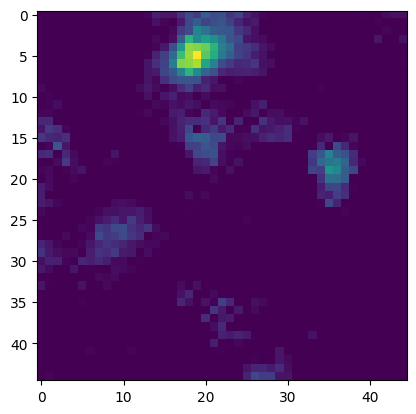

In [ ]:
plt.imshow(im_noisy[4, :, :, 2])

### Run Diffusion

In [ ]:
# The number of sampling steps.
num_steps = 1000  # @param {'type':'integer'}
exp_constant = config.exp_constant

In [ ]:
samples = Euler_Maruyama_sampler(
    rng=rng,
    params=UNet_params,
    marginal_prob_std=marginal_prob_std,
    diffusion_coeff=diffusion_coeff,
    start_time=config.t_max_val,
    initial_rep=noisy_images,
    batch_size=config.vae_config.batch_size,
    num_steps=num_steps,
    exp_constant=exp_constant,
    eps=1e-1,
)

100%|██████████| 1000/1000 [00:55<00:00, 18.09it/s]


In [ ]:
samples.shape

(100, 12, 12, 1)

In [ ]:
im = decoder_model.apply({"params": decoder_params}, samples)

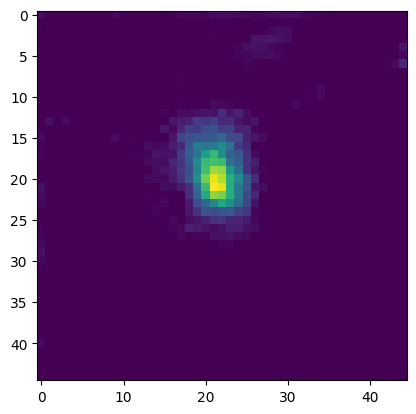

In [ ]:
plt.imshow(im[4, :, :, 2])

In [ ]:
# marginal_prob_std(jnp.linspace(.5, 1e-1, num_steps), 25)